In [1]:
import mmcv
import matplotlib.pyplot as plt

import os.path as osp
import numpy as np
from PIL import Image
import os
import sys
import ade_custom
import matplotlib.patches as mpatches
import random

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import mmseg
print(mmseg.__version__)

import shutil
import random
from glob import glob
import json

1.11.0 True
0.28.0


In [2]:
# data 경로 설정


# data 경로 설정
data_root = '/mmsegmentation/data/36-3/'
img_path = data_root + 'img_dir/'
ann_path = data_root + 'ann_dir/'
img_paths = glob(img_path+'*')
ann_paths = glob(ann_path+'*')
img_move_path = data_root + 'img_val/'
ann_move_path = data_root + 'ann_val/'
img_move_path_t = data_root + 'img_test/'
ann_move_path_t = data_root + 'ann_test/'
label_path = '/mmsegmentation/data/3_label/'
label_folder = glob(label_path+'*')

In [5]:
from mmcv import Config

cfg = Config.fromfile('/mmsegmentation/upernet_swin_base_patch4_window12_512x512_160k_ade20k_pretrain_384x384_22K.py')

In [6]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = dict(type='LN', requires_grad=True)
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 31
cfg.model.auxiliary_head.num_classes = 31

# Modify dataset type and path
cfg.dataset_type = 'ADE20KDataset'
cfg.data_root = '/mmsegmentation/data/36-3/'
# batch_size
cfg.data.samples_per_gpu = 16
cfg.data.workers_per_gpu= 4

cfg.img_norm_cfg = dict(
    # mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
      mean=[112.71, 108.37, 106.84], std=[49.51, 43.76, 43.01], to_rgb=True)
    #mean=[0, 0, 0], std=[1, 1, 1], to_rgb=True)
    # mean=[106.84, 108.37, 112.71], std=[43.01, 43.76, 49.51], to_rgb=True)
#cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label = False),
    dict(type='Resize', img_scale=(512, 512)),
    #dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    #dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
 
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_path
cfg.data.train.ann_dir = ann_path
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_move_path
cfg.data.val.ann_dir = ann_move_path
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_move_path_t
cfg.data.test.ann_dir = ann_move_path_t
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/test.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
# cfg.load_from = '/mmsegmentation/upernet_swin_base_patch4_window12_512x512_160k_ade20k_pretrain_384x384_22K_20210531_125459-429057bf.pth'

cfg.load_from = '/mmsegmentation/data/result/36-3/test0923/iter_32000.pth'
# Set up working dir to save files and logs.
cfg.work_dir = '/mmsegmentation/data/result/36-3/test0923/'

cfg.runner.max_iters = 32000
cfg.log_config.interval = 200
cfg.evaluation.interval = 800
cfg.checkpoint_config.interval = 1600

# Set seed to facitate reproducing the result
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
backbone_norm_cfg = dict(type='LN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        pretrain_img_size=384,
        embed_dims=128,
        patch_size=4,
        window_size=12,
        mlp_ratio=4,
        depths=[2, 2, 18, 2],
        num_heads=[4, 8, 16, 32],
        strides=(4, 2, 2, 2),
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        patch_norm=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.3,
        use_abs_pos_embed=False,
        act_cfg=dict(type='GELU'),
        norm_cfg=dict(type='LN', requires_grad=True),
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/swin/swin_base_patch4_window12_384_22k_20220317-e5c09f74.pth'
        )),
    decode_head=dict(
       

In [7]:
from mmseg.datasets import build_dataset, build_dataloader
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Clear Cache
torch.cuda.empty_cache()

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)

2022-09-27 00:58:50,403 - mmseg - INFO - Loaded 6399 images


In [13]:
classes = (
        'vehicle', 'bus', 'truck', 'policeCar', 'ambulance', 'schoolBus', 'otherCar', 
        'motorcycle', 'bicycle', 'twoWheeler', 'pedestrian', 'rider', 'freespace',
        'curb', 'sidewalk', 'crossWalk', 'safetyZone', 'speedBump', 'roadMark', 'whiteLane',
        'yellowLane', 'blueLane', 'redLane', 'stopLane', 'constructionGuide', 'trafficDrum',
        'rubberCone', 'trafficSign', 'trafficLight', 'warningTriangle', 'fence'
    )
palette =[
                [128, 0, 0], [0, 128, 0], [0, 0, 128], [128, 128, 0],  [128, 0, 128], [0, 128, 128], [128, 128, 128], 
                [64, 0, 0], [0, 64, 0], [0, 0, 64], [64, 64, 0],  [64, 0, 64], [0, 64, 64], [64, 64, 64], 
                [192, 0, 0], [0, 192, 0], [0, 0, 192], [192, 192, 0],  [192, 0, 192], [0, 192, 192], [192, 192, 192], 
                [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], 
                [192, 128, 128], [128, 64, 0], [0, 192, 128], [128, 192, 0], [0, 64, 128]
                    ]


In [14]:
img = mmcv.imread('/mmsegmentation/data/36-3/img_test/16_105537_220617_54.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

AttributeError: 'EncoderDecoder' object has no attribute 'CLASSES'

<Figure size 576x432 with 0 Axes>

In [9]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

model.eval()

img = mmcv.imread('/mmsegmentation/data/36-3/img_test/16_105537_220617_54.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
print(result)
# plt.figure(figsize=(8, 6))
# show_result_pyplot(model, img, result, palette)

[array([[24, 24, 24, ..., 25, 25, 25],
       [24, 24, 24, ..., 25, 25, 25],
       [24, 24, 24, ..., 25, 25, 25],
       ...,
       [24, 24, 24, ..., 11, 11, 11],
       [24, 24, 24, ..., 11, 11, 11],
       [24, 24, 24, ..., 11, 11, 11]])]


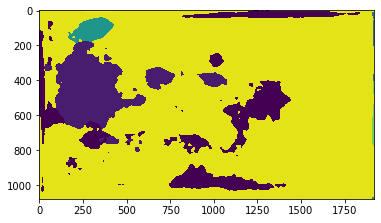

In [10]:
from matplotlib import pyplot as plt
plt.imshow(result[0], interpolation='nearest')
plt.show()

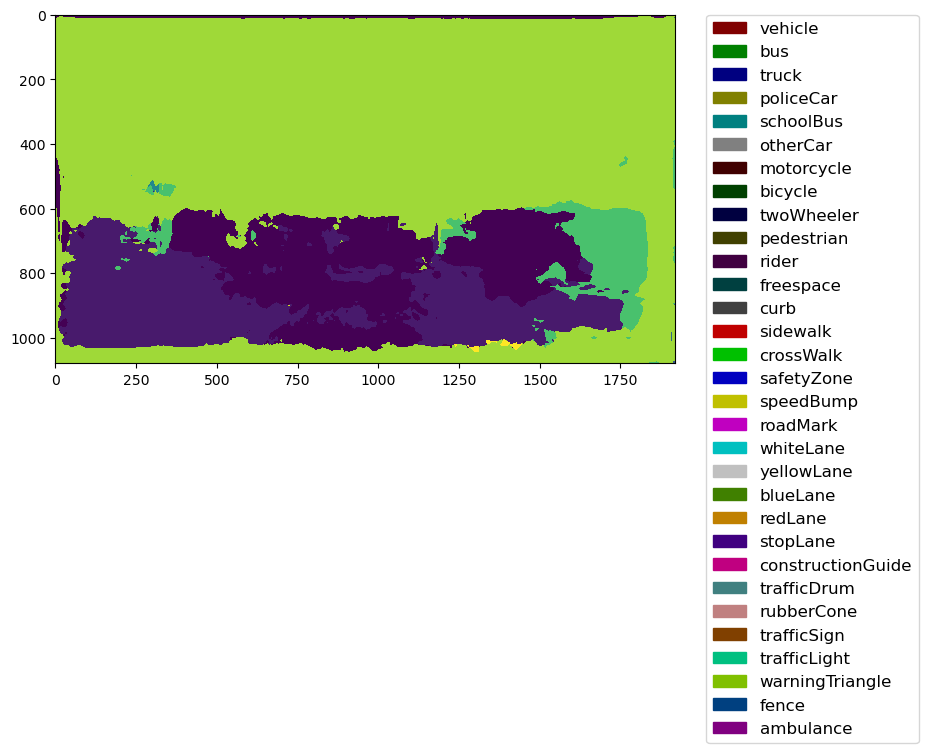

In [13]:
plt.figure(figsize=(8, 6))
im = plt.imshow(result[0], interpolation='nearest')

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(31)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()